In [10]:
import numpy as np
import pandas as pd
import time
import os
import tensorflow as tf
tf.config.run_functions_eagerly(False)
from VaDER.vader import VADER

save_path = os.path.join('test_vader', 'vader.ckpt')

np.random.seed(123)

In [11]:
X = np.load('../DL-WORKSHOP/npy_files/features_All25.npy')
y = np.load('../DL-WORKSHOP/npy_files/labels_All25.npy')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labs = le.fit_transform(y)
print(len(X),len(y))
X_train, y_train = X, labs

1878 1878


In [13]:
pd.Series(y).value_counts()

G4     286
F4     254
D7     210
D4     198
D3     195
D2     153
G2     136
E6     118
F3      78
F2      54
G5      44
G6      43
G3      38
E7      35
E8      26
E9       6
E10      4
dtype: int64

In [16]:
# normalize (better for fitting)
for i in np.arange(X_train.shape[2]):
    X_train[:,:,i] = (X_train[:,:,i] - np.mean(X_train[:,:,i])) / np.std(X_train[:,:,i])

In [17]:
W_train = None

In [ ]:
vader = VADER(X_train=X_train, W_train=W_train, save_path=save_path, n_hidden=[64,32,8], k=3,
              learning_rate=1e-3, output_activation=None, recurrent=True, cell_type="GRU", batch_size=64)
# pre-train without latent loss
start = time.time()
vader.pre_fit(n_epoch=64, verbose=True)
# train with latent loss
vader.fit(n_epoch=64, verbose=True)
end = time.time()
print("Elapsed: ", end - start)

In [19]:
# get the clusters
c = vader.cluster(X_train)
# get the re-constructions
p = vader.predict(X_train)
# compute the loss given the network
l = vader.get_loss(X_train)

In [20]:
print(pd.Series(c).value_counts())

2    1363
1     426
0      89
dtype: int64


In [21]:
latent = vader.map_to_latent(X_train)

In [22]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import numpy as np
from random import randint
import os
import matplotlib.pyplot as plt

def plot_clustering_matplotlib(z_run, labels):

    labels = labels[:z_run.shape[0]] # because of weird batch_size

    hex_colors = []
    for _ in np.unique(labels):
        hex_colors.append('#%06X' % randint(0, 0xFFFFFF))

    colors = [hex_colors[int(i)] for i in labels]

    z_run_pca = TruncatedSVD(n_components=2).fit_transform(z_run)
    z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

    plt.scatter(z_run_pca[:, 0], z_run_pca[:, 1], c=colors, marker='*', linewidths=0)
    plt.title('PCA on z_run')
    plt.show()

    plt.scatter(z_run_tsne[:, 0], z_run_tsne[:, 1], c=colors, marker='*', linewidths=0)
    plt.title('tSNE on z_run')
    plt.show()

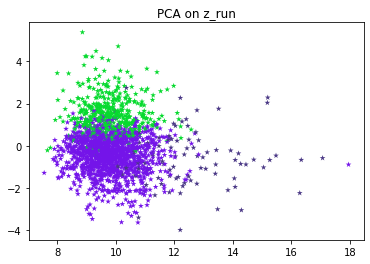

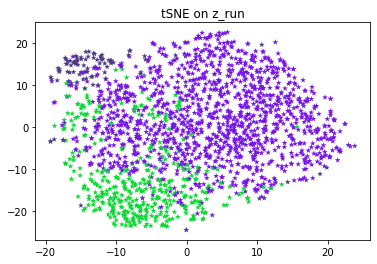

In [23]:
plot_clustering_matplotlib(latent,c)

## specific well clusters

In [ ]:
X_G4 = np.array([x for x,well in zip(X,y) if well == "E6"])
specific_c = vader.cluster(X_G4)
specific_latent = vader.map_to_latent(X_G4)
print(pd.Series(specific_c).value_counts())

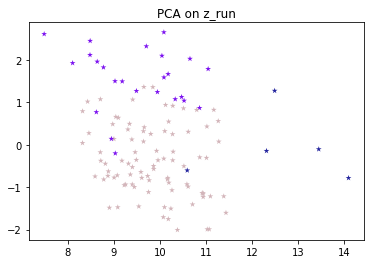

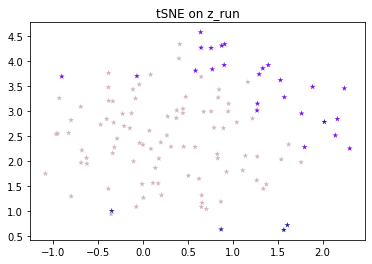

In [33]:
plot_clustering_matplotlib(specific_latent,specific_c)

## Transformer

In [ ]:
vader = VADER(X_train=X_train, W_train=W_train, save_path=save_path, n_hidden=[64,4], k=3,
              learning_rate=1e-3, output_activation=None, recurrent=True, cell_type="Transformer", batch_size=64,
              cell_params={'d_model': 4, 'num_layers': 1, 'num_heads': 1, 'dff': 16, 'rate': 0.0})
# pre-train without latent loss
start = time.time()
vader.pre_fit(n_epoch=50, verbose=True)
# train with latent loss
vader.fit(n_epoch=50, verbose=True)
end = time.time()
print("Elapsed: ", end - start)

In [41]:
# get the clusters
c_trans = vader.cluster(X_train)
# get the re-constructions
p_trans = vader.predict(X_train)
# compute the loss given the network
l_trans = vader.get_loss(X_train)
latent_trans = vader.map_to_latent(X_train)

In [42]:
print(pd.Series(c_trans).value_counts())

1    1878
dtype: int64


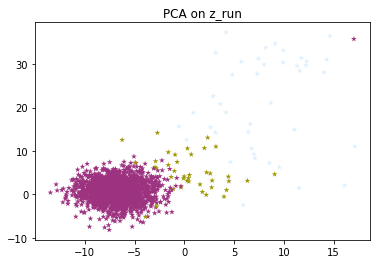

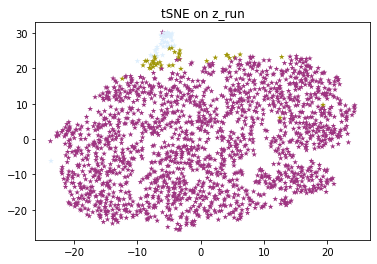

In [39]:
plot_clustering_matplotlib(latent_trans,c_trans)